In [1]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP, ProjectToTangent, WrappedVF
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import plot_flow_on_sphere, plot_3d_points
from utils.manifold_utils import infer_model, step

from flow_matching.utils.manifolds import Manifold, Sphere
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Using LASA DataSet from /home/stanislav/anaconda3/envs/ml_env/lib/python3.12/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
torch.manual_seed(3420934659826)

In [3]:
run_parameters =  yaml.safe_load(Path("./configs/general.yaml").read_text())
run_parameters

{'lr': 0.0001,
 'epochs': 30001,
 'batch_size': 1200,
 'inf_every': 2000,
 'print_every': 500,
 'dim': 3,
 'hidden_dim': 64,
 'horizon_size': 8,
 'inference_horizon': 4,
 'scale_factor': 2.0,
 'downsample': 5,
 'mean': 0.0,
 'std': 0.8,
 'ema_warmup': 1000,
 'ema_update': 5,
 'ema_decay': 0.999,
 'inf_runs_num': 3,
 'save_epoch': 6000,
 'device': 'cpu',
 'manifold': 'Sphere'}

In [4]:
manifold_types = {'None' : None, 'Sphere':Sphere()}

In [5]:
manifold = manifold_types[run_parameters['manifold']]

sine_data = StatePyLASADataset("Sine", horizon_size=run_parameters['horizon_size'],
                                       scaling_factor=run_parameters['scale_factor'],
                                       downsample = run_parameters['downsample'],
                                       manifold=manifold)

train_dataset = torch.utils.data.Subset(sine_data, range(6000//run_parameters['downsample']))

test_dataset = torch.utils.data.Subset(sine_data, range(6000//run_parameters['downsample'], 
                                                        7000//run_parameters['downsample']))

train_sin = DataLoader(train_dataset,
                       batch_size=run_parameters['batch_size'],
                       shuffle=True)

val_sin = DataLoader(test_dataset,
                    batch_size=run_parameters['batch_size'],
                    shuffle=True)

test_sin = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _ = next(iter(test_sin))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=1000//run_parameters['downsample'],
                    shuffle=False)

gt_obs, gt_horizon = next(iter(gt_test))

In [6]:
vf = StateMLP(
    action_dim=run_parameters['dim'],
    hidden_dim=run_parameters['hidden_dim'],
    horizon_size=run_parameters['horizon_size'],
)

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema_decay'],
)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable param number:", params)

Learnable param number: 42032


| iter      0 |  0.18 ms/step | train loss    0.314 
| iter      0 | validation loss:    0.317 


100%|██████████| 60/60 [00:02<00:00, 25.80it/s]


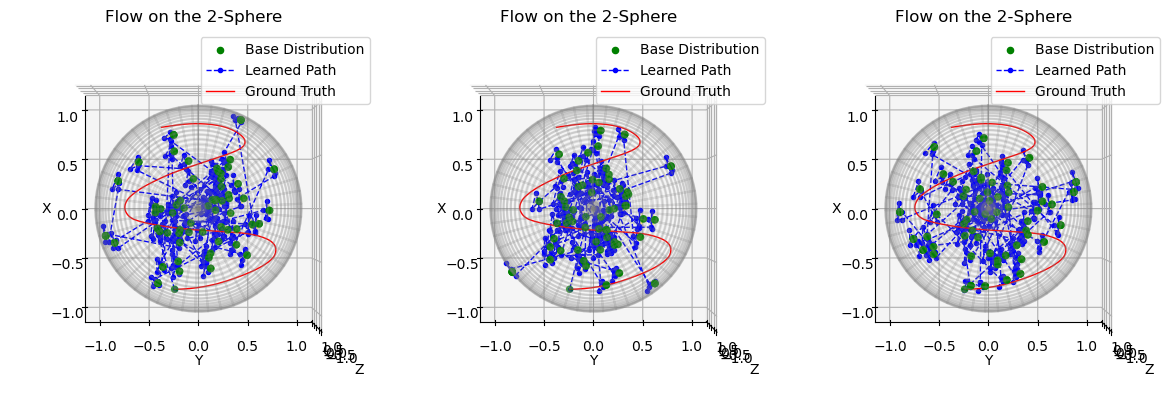

| iter    500 | 39.05 ms/step | train loss    0.109 
| iter    500 | validation loss:    0.320 
| iter   1000 | 22.74 ms/step | train loss    0.042 
| iter   1000 | validation loss:    0.351 
| iter   1500 | 23.41 ms/step | train loss    0.033 
| iter   1500 | validation loss:    0.029 
| iter   2000 | 22.91 ms/step | train loss    0.028 
| iter   2000 | validation loss:    0.031 


100%|██████████| 60/60 [00:02<00:00, 25.61it/s]


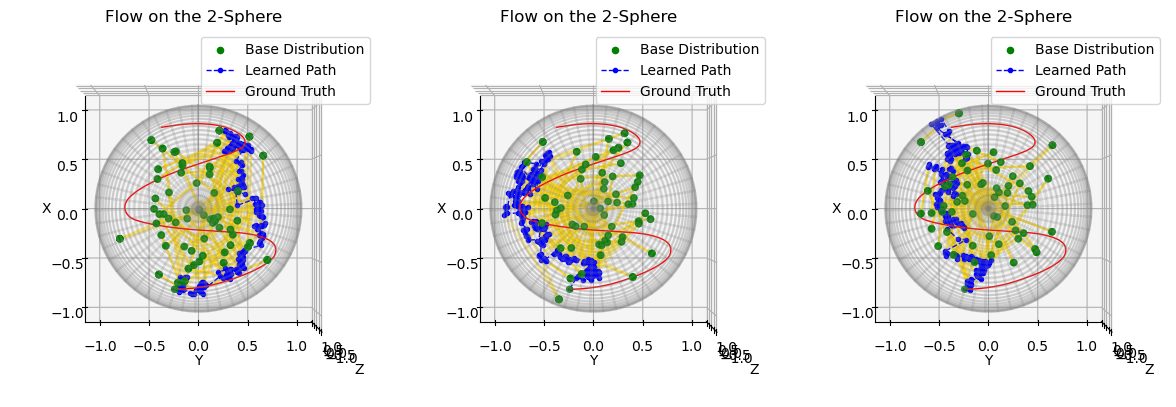

| iter   2500 | 38.74 ms/step | train loss    0.025 
| iter   2500 | validation loss:    0.030 
| iter   3000 | 23.36 ms/step | train loss    0.020 
| iter   3000 | validation loss:    0.017 
| iter   3500 | 22.59 ms/step | train loss    0.018 
| iter   3500 | validation loss:    0.022 
| iter   4000 | 23.38 ms/step | train loss    0.018 
| iter   4000 | validation loss:    0.015 


100%|██████████| 60/60 [00:02<00:00, 25.73it/s]


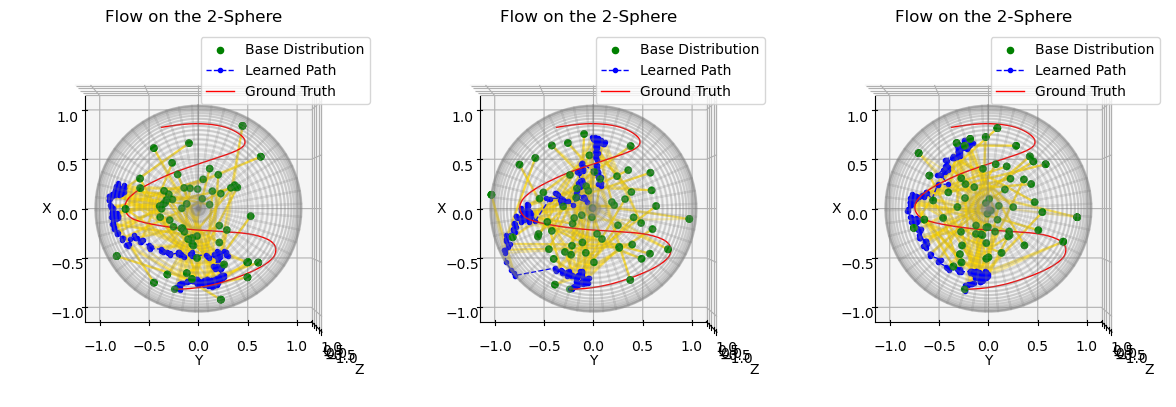

| iter   4500 | 37.73 ms/step | train loss    0.015 
| iter   4500 | validation loss:    0.026 
| iter   5000 | 23.91 ms/step | train loss    0.014 
| iter   5000 | validation loss:    0.012 
| iter   5500 | 22.12 ms/step | train loss    0.013 
| iter   5500 | validation loss:    0.015 
| iter   6000 | 22.76 ms/step | train loss    0.016 
| iter   6000 | validation loss:    0.015 


100%|██████████| 60/60 [00:02<00:00, 26.11it/s]


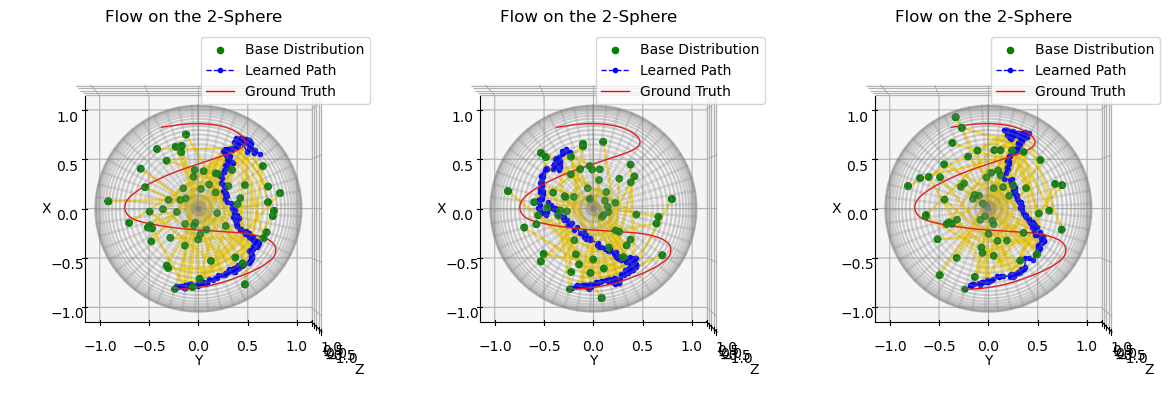

| iter   6500 | 37.92 ms/step | train loss    0.014 
| iter   6500 | validation loss:    0.011 
| iter   7000 | 22.70 ms/step | train loss    0.012 
| iter   7000 | validation loss:    0.015 
| iter   7500 | 23.77 ms/step | train loss    0.010 
| iter   7500 | validation loss:    0.011 
| iter   8000 | 23.47 ms/step | train loss    0.011 
| iter   8000 | validation loss:    0.010 


100%|██████████| 60/60 [00:02<00:00, 25.96it/s]


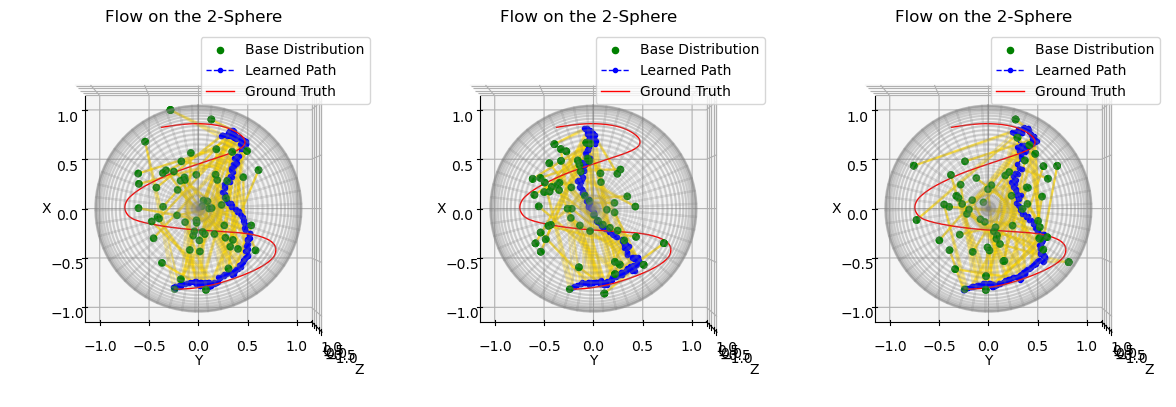

| iter   8500 | 36.44 ms/step | train loss    0.012 
| iter   8500 | validation loss:    0.010 
| iter   9000 | 20.96 ms/step | train loss    0.011 
| iter   9000 | validation loss:    0.009 
| iter   9500 | 21.55 ms/step | train loss    0.010 
| iter   9500 | validation loss:    0.011 
| iter  10000 | 21.17 ms/step | train loss    0.010 
| iter  10000 | validation loss:    0.010 


100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


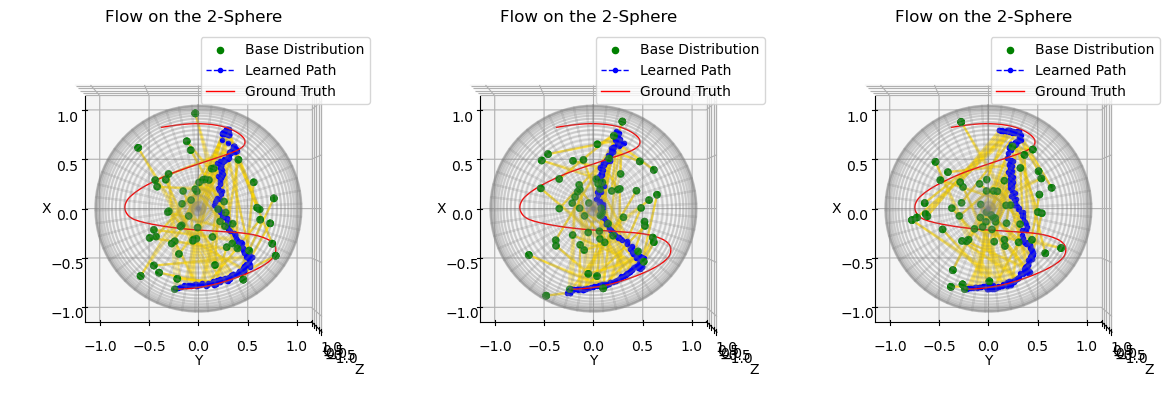

| iter  10500 | 36.68 ms/step | train loss    0.011 
| iter  10500 | validation loss:    0.010 
| iter  11000 | 22.00 ms/step | train loss    0.008 
| iter  11000 | validation loss:    0.008 
| iter  11500 | 20.28 ms/step | train loss    0.008 
| iter  11500 | validation loss:    0.011 
| iter  12000 | 21.59 ms/step | train loss    0.008 
| iter  12000 | validation loss:    0.007 


100%|██████████| 60/60 [00:02<00:00, 25.69it/s]


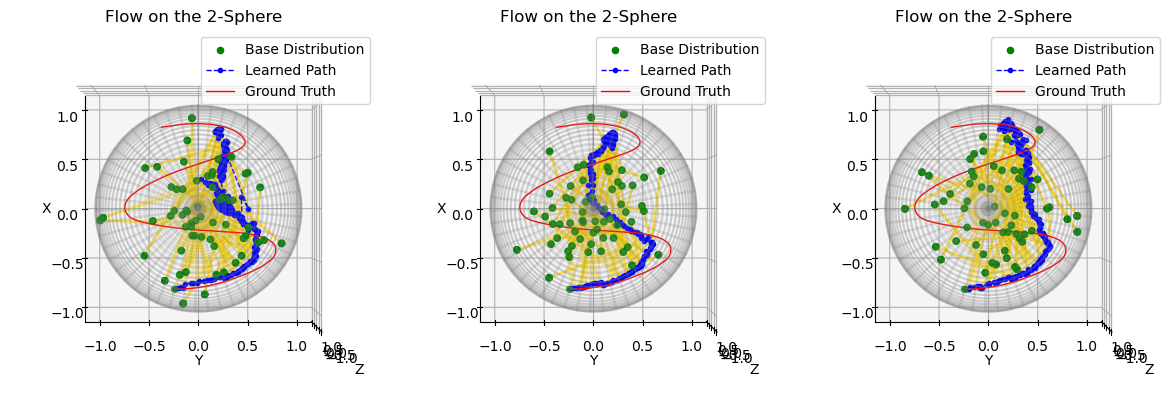

| iter  12500 | 39.03 ms/step | train loss    0.009 
| iter  12500 | validation loss:    0.013 
| iter  13000 | 23.76 ms/step | train loss    0.009 
| iter  13000 | validation loss:    0.009 
| iter  13500 | 23.63 ms/step | train loss    0.010 
| iter  13500 | validation loss:    0.006 
| iter  14000 | 22.89 ms/step | train loss    0.008 
| iter  14000 | validation loss:    0.009 


100%|██████████| 60/60 [00:02<00:00, 26.17it/s]


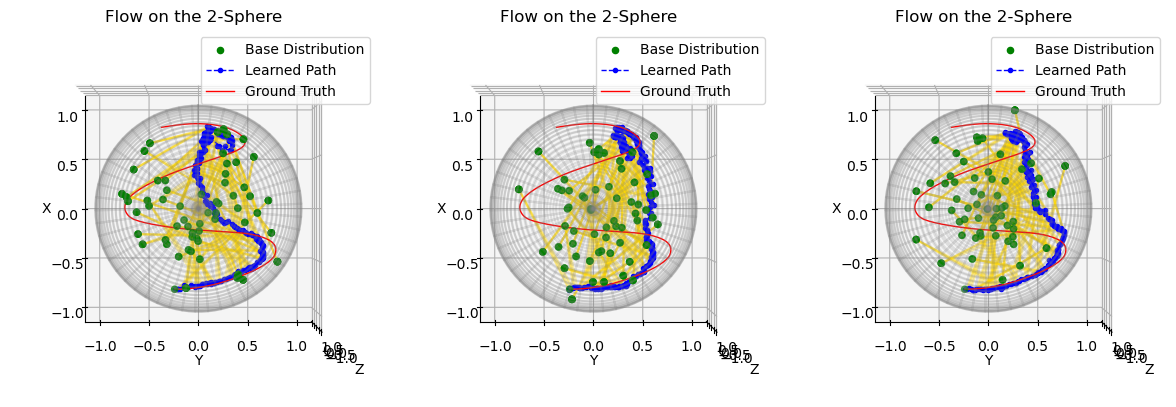

| iter  14500 | 37.99 ms/step | train loss    0.009 
| iter  14500 | validation loss:    0.011 
| iter  15000 | 23.90 ms/step | train loss    0.007 
| iter  15000 | validation loss:    0.009 
| iter  15500 | 23.69 ms/step | train loss    0.008 
| iter  15500 | validation loss:    0.010 
| iter  16000 | 23.40 ms/step | train loss    0.007 
| iter  16000 | validation loss:    0.005 


100%|██████████| 60/60 [00:02<00:00, 26.15it/s]


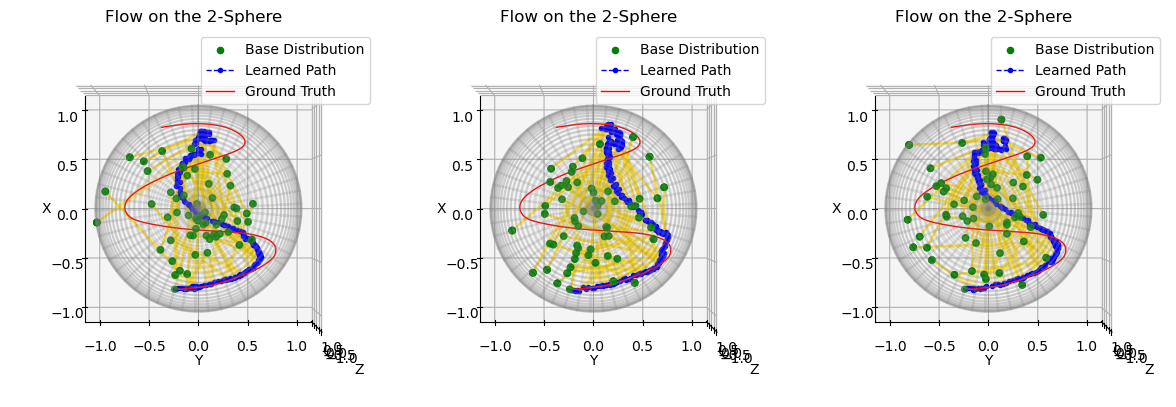

| iter  16500 | 38.26 ms/step | train loss    0.007 
| iter  16500 | validation loss:    0.008 
| iter  17000 | 23.21 ms/step | train loss    0.006 
| iter  17000 | validation loss:    0.006 
| iter  17500 | 23.46 ms/step | train loss    0.007 
| iter  17500 | validation loss:    0.007 
| iter  18000 | 23.58 ms/step | train loss    0.007 
| iter  18000 | validation loss:    0.013 


100%|██████████| 60/60 [00:02<00:00, 25.05it/s]


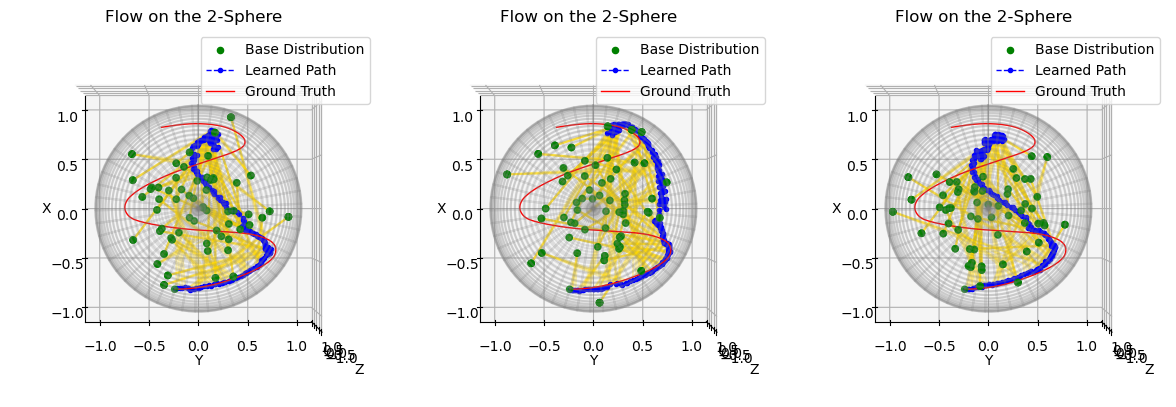

| iter  18500 | 39.18 ms/step | train loss    0.007 
| iter  18500 | validation loss:    0.006 
| iter  19000 | 22.58 ms/step | train loss    0.006 
| iter  19000 | validation loss:    0.009 
| iter  19500 | 23.18 ms/step | train loss    0.008 
| iter  19500 | validation loss:    0.007 
| iter  20000 | 23.62 ms/step | train loss    0.006 
| iter  20000 | validation loss:    0.006 


100%|██████████| 60/60 [00:02<00:00, 25.81it/s]


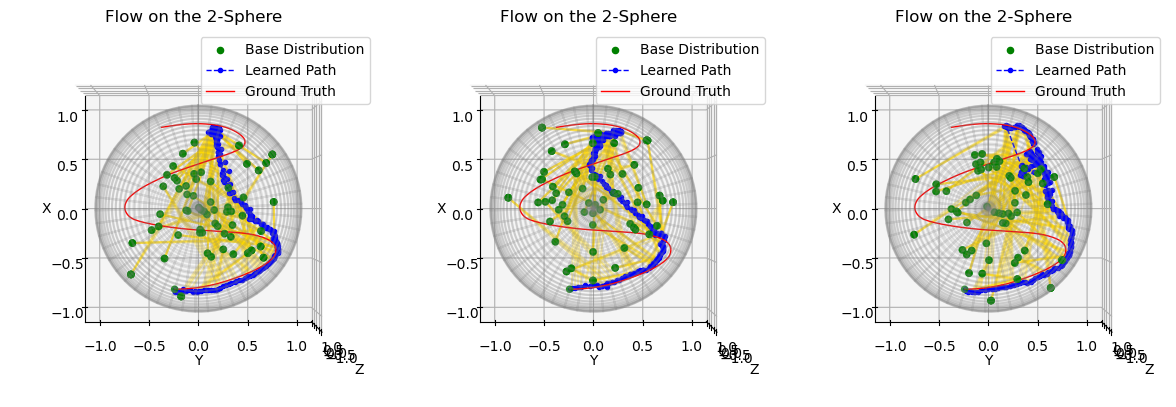

| iter  20500 | 38.34 ms/step | train loss    0.006 
| iter  20500 | validation loss:    0.007 
| iter  21000 | 23.50 ms/step | train loss    0.006 
| iter  21000 | validation loss:    0.006 
| iter  21500 | 23.03 ms/step | train loss    0.006 
| iter  21500 | validation loss:    0.010 
| iter  22000 | 22.49 ms/step | train loss    0.007 
| iter  22000 | validation loss:    0.008 


100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


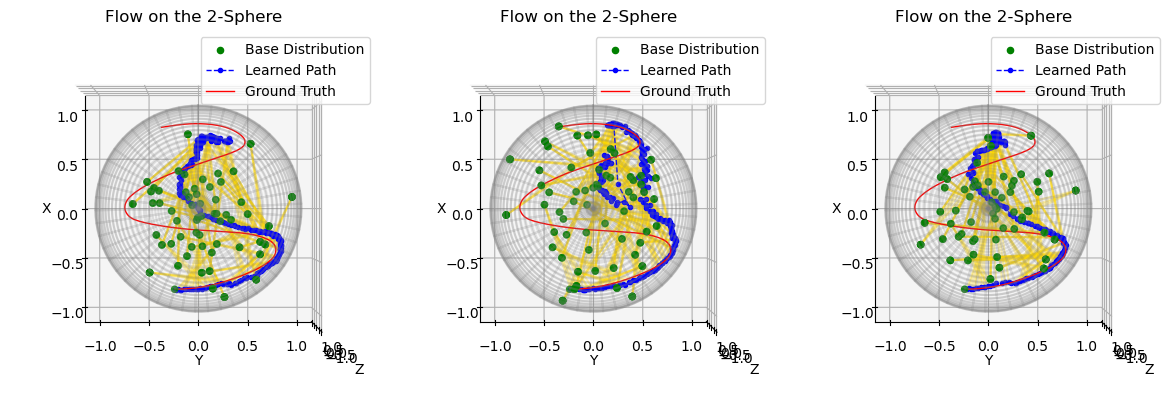

| iter  22500 | 38.51 ms/step | train loss    0.005 
| iter  22500 | validation loss:    0.006 
| iter  23000 | 23.69 ms/step | train loss    0.005 
| iter  23000 | validation loss:    0.003 
| iter  23500 | 22.76 ms/step | train loss    0.006 
| iter  23500 | validation loss:    0.008 
| iter  24000 | 23.27 ms/step | train loss    0.004 
| iter  24000 | validation loss:    0.005 


100%|██████████| 60/60 [00:02<00:00, 25.61it/s]


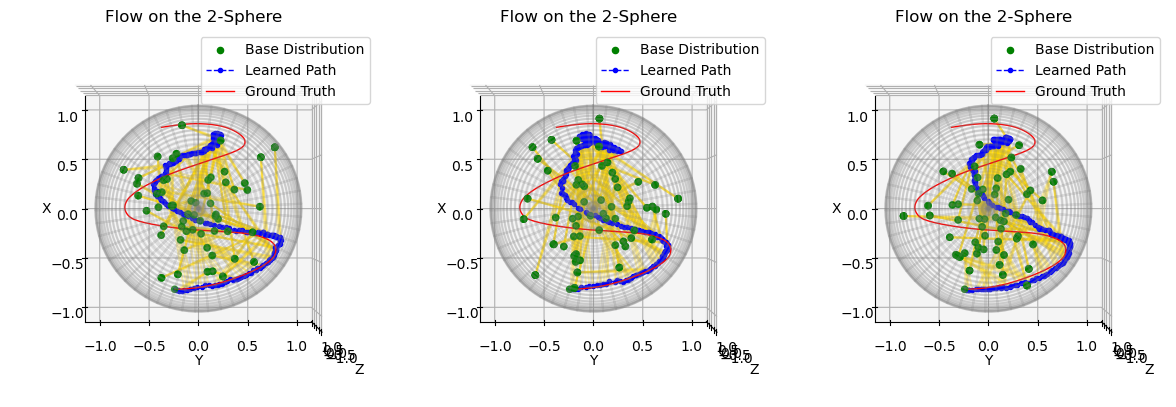

| iter  24500 | 38.18 ms/step | train loss    0.005 
| iter  24500 | validation loss:    0.004 
| iter  25000 | 23.79 ms/step | train loss    0.005 
| iter  25000 | validation loss:    0.005 
| iter  25500 | 23.49 ms/step | train loss    0.005 
| iter  25500 | validation loss:    0.008 
| iter  26000 | 23.65 ms/step | train loss    0.005 
| iter  26000 | validation loss:    0.009 


100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


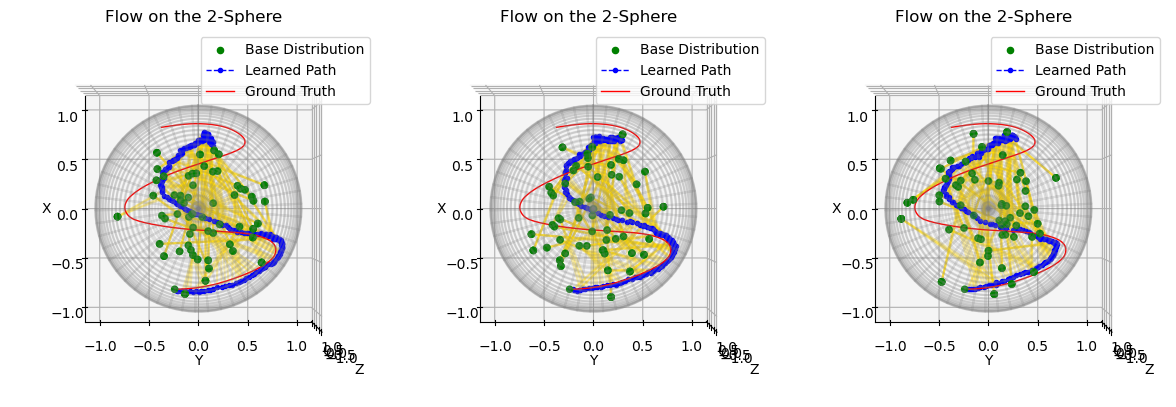

| iter  26500 | 36.79 ms/step | train loss    0.005 
| iter  26500 | validation loss:    0.005 
| iter  27000 | 21.49 ms/step | train loss    0.004 
| iter  27000 | validation loss:    0.004 
| iter  27500 | 20.03 ms/step | train loss    0.005 
| iter  27500 | validation loss:    0.006 
| iter  28000 | 20.35 ms/step | train loss    0.005 
| iter  28000 | validation loss:    0.004 


100%|██████████| 60/60 [00:02<00:00, 26.24it/s]


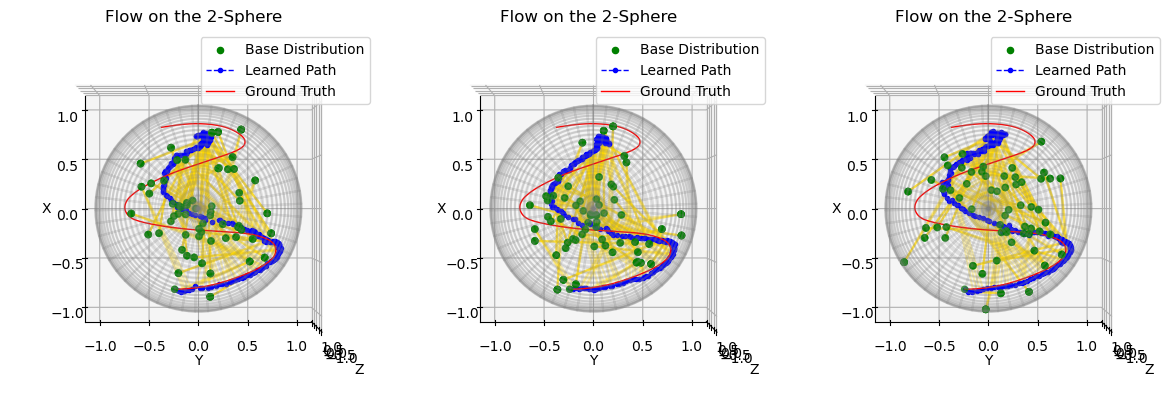

| iter  28500 | 35.24 ms/step | train loss    0.004 
| iter  28500 | validation loss:    0.003 
| iter  29000 | 21.88 ms/step | train loss    0.005 
| iter  29000 | validation loss:    0.003 
| iter  29500 | 21.42 ms/step | train loss    0.005 
| iter  29500 | validation loss:    0.004 
| iter  30000 | 21.24 ms/step | train loss    0.004 
| iter  30000 | validation loss:    0.004 


100%|██████████| 60/60 [00:02<00:00, 25.99it/s]


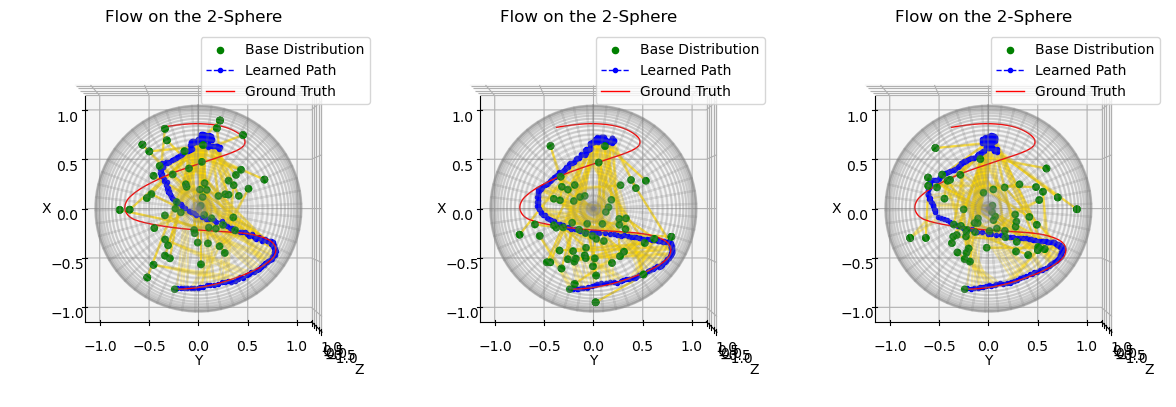

In [7]:
device = run_parameters['device']
vf.to(device)

optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['lr'])

path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

start_time = time.time()
for i in range(run_parameters['epochs']):
  for batch in train_sin:
    optim.zero_grad()

    train_loss = step(vf=vf, 
                      batch=batch, 
                      run_parameters=run_parameters, 
                      manifold=manifold, 
                      path=path, 
                      device=device)
    
    train_loss.backward()
    optim.step()

    if i > run_parameters['ema_warmup'] and i % run_parameters['ema_update'] == 0: 
      ema_vf.update()

    if i % run_parameters['print_every'] == 0:
      elapsed = time.time() - start_time
      print('| iter {:6d} | {:5.2f} ms/step | train loss {:8.3f} '
            .format(i, elapsed*1000/run_parameters['print_every'], train_loss.item()))
      
      with torch.no_grad():
        ema_vf.store()
        ema_vf.copy_to()
        loss_val = step(vf=vf, 
                        batch=next(iter(val_sin)), 
                        run_parameters=run_parameters, 
                        manifold=manifold, 
                        path=path, 
                        device=device)
        ema_vf.restore()
        print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val))
      start_time = time.time()

    if i % run_parameters['inf_every'] == 0:
        with torch.no_grad():
            results = []
            samples = []
            ema_vf.store()
            ema_vf.copy_to()
            for _ in range(run_parameters['inf_runs_num']):
                res, samp = infer_model(model=vf, 
                                start=gt_obs[0,:run_parameters['dim']], 
                                manifold=manifold,
                                model_horizon=run_parameters['horizon_size'],
                                inference_horizon=run_parameters['inference_horizon'],
                                sample_points=run_parameters['batch_size'] // run_parameters['downsample'],
                                mean=run_parameters['mean'],
                                std=run_parameters['std'])
                results.append(res)
                samples.append(samp)
            ema_vf.restore()
            plot_flow_on_sphere(results, samples, gt_obs)


In [9]:
torch.save(vf.state_dict(), "./vf_3d" + str(run_parameters['scale_factor']) + "_" + str(30000) + ".pth")

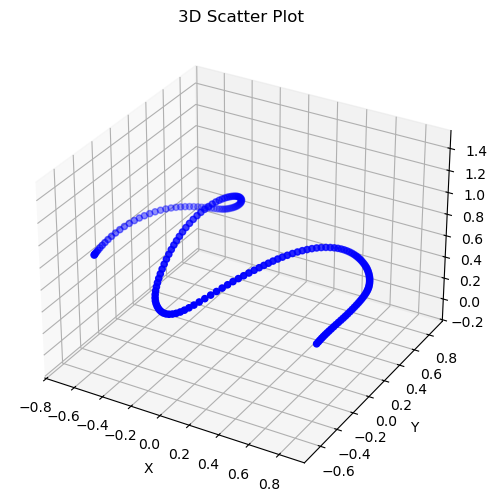

In [10]:
plot_3d_points(gt_obs[:, :3])

100%|██████████| 72/72 [00:02<00:00, 25.45it/s]


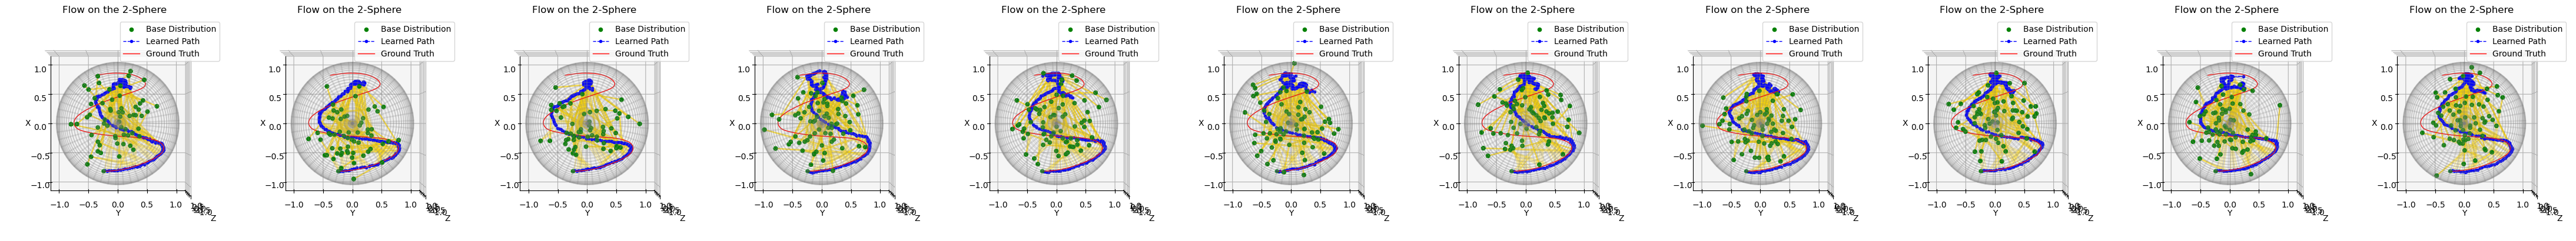

In [11]:
for _ in range(8):
    res, samp = infer_model(model=vf, 
                    start=gt_obs[0,:run_parameters['dim']], 
                    manifold=manifold,
                    model_horizon=run_parameters['horizon_size'],
                    inference_horizon=run_parameters['inference_horizon'],
                    sample_points=int(run_parameters['batch_size'] // run_parameters['downsample'] * 1.2),
                    mean=run_parameters['mean'],
                    std=run_parameters['std'])
    results.append(res)
    samples.append(samp)
plot_flow_on_sphere(results, samples, gt_obs)

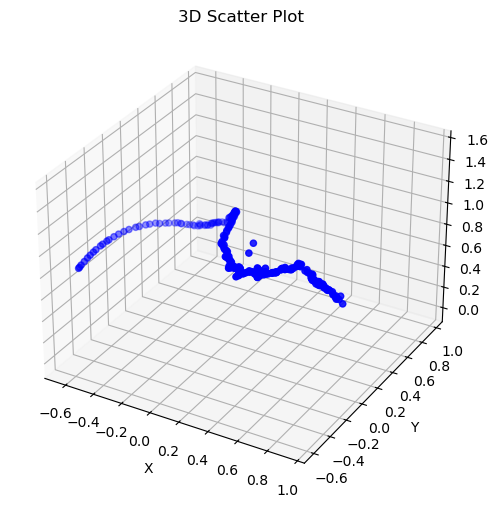

In [14]:
plot_3d_points(results[4])

In [11]:
def plot_points(points, 
                title="3D Scatter Plot", 
                color="blue", 
                s=20, 
                show_grid=True,
                elev=0,
                azim=0):
    if isinstance(points, torch.Tensor):
        points = points.cpu().numpy()  # Convert from PyTorch to NumPy if needed

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

   # print(points.shape)

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=color, s=s)

    # Labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)

    # Optional grid
    ax.grid(show_grid)

    # Set equal aspect ratio
    max_range = (points.max() - points.min()) / 2
    mid = points.mean(axis=0)
    # ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    # ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    # ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.2)

    # Adjust view to center the north pole
    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Flow on the 2-Sphere")
    
    plt.tight_layout()
    # Interactive rotation
    plt.show()

In [67]:
x0 = a0[:3, :3, :3]
x1 = a1[:3, :3, :3]
path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

In [68]:
print(x0.contiguous().view(x0.shape[0] * x0.shape[1], x0.shape[2]).shape)

torch.Size([9, 3])


In [69]:
traj_t = [x0]

In [70]:
for t in torch.linspace(0.0, 1.0, steps=100):
    #print(x0.unsqueeze(0).repeat(2,1).shape)
    path_sample = path.sample(t=t.unsqueeze(0).repeat(x0.shape[0] * x0.shape[1]), 
                              x_0=x0.contiguous().view(x0.shape[0] * x0.shape[1], x0.shape[2]), 
                              x_1=x1.contiguous().view(x0.shape[0] * x0.shape[1], x0.shape[2]))
    traj_t.append(path_sample.dx_t.view(x0.shape[0], x0.shape[1], x0.shape[2]))

In [71]:
traj_t = torch.stack(traj_t[1:], dim=0)

In [72]:
print(traj_t.shape)

torch.Size([100, 3, 3, 3])


In [75]:
print((traj_t[:,2,0,:]**2).sum(axis=1))

tensor([0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887, 0.9887,
        0.9887])


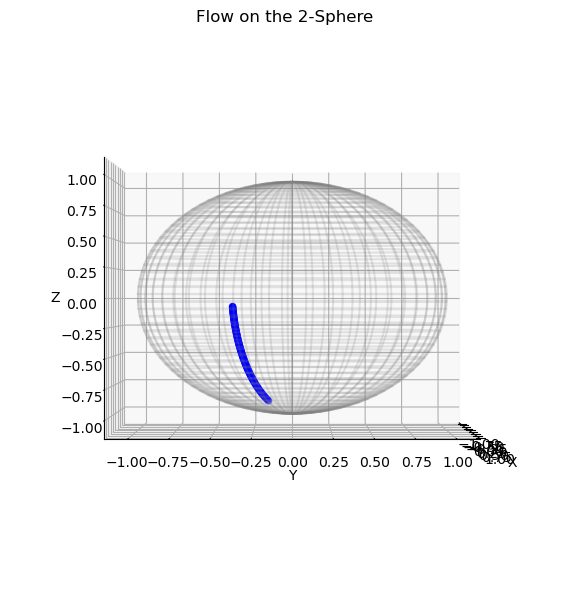

In [76]:
plot_points(traj_t[:,2,0,:], elev=0, azim=0)